# Kaggle Titanic whit simple Decision Tree

**Step**
1. Explore df
2. Missing values and feature engineering
3. Stat Explore
4. Predictive Modeling
5. Submission

##Explore df

### Import lib

In [147]:
#import drive dir
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
!pip install seaborn

In [149]:
# for explore df
import os
import glob
import warnings
warnings.filterwarnings('ignore')
# from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None) # set the number of characters visible for each cell of the column
# ex. 50 = first 50 characters
# None = full text
# from matplotlib import pyplot
import matplotlib.pyplot as plt
# import matplotlib.pylab as pltlab

# for pre-processing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# for stat explore
import seaborn as sns

# for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, classification_report, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# lLbrary to compute time measures
import time
import datetime

def local_time():
    # dd/mm/YY H:M:S
    print("Start at " + datetime.datetime.now().strftime("%H:%M:%S"))	

local_time()

Start at 12:42:38


###Def path

In [150]:
# paths
drive_dir = 'drive'
root = f'/content/{drive_dir}/MyDrive/Kaggle_Titanic_DecisionTree/'
staging_path = f'staging/'
try:
  os.mkdir(f'{root}{staging_path}')
  print(f'New path {staging_path} created\n')
except Exception as e:
  print(e)
test = 'test.csv'
train = 'train.csv'
chi_s_table = '/content/drive/MyDrive/Chi_square.csv'
submission = 'submission.csv'

[Errno 17] File exists: '/content/drive/MyDrive/Kaggle_Titanic_DecisionTree/staging/'


In [151]:
# import file to pandas
train = pd.read_csv(f'{root}{train}')
test = pd.read_csv(f'{root}{test}')
sub = (f'{root}{submission}')
chi_square_table = pd.read_csv(f'{chi_s_table}')
staging = f'{root}{staging_path}'

### Explore df

In [152]:
print('TRAIN INFO')
print(f'{train.info()}\n')
print(f'COUNT NAN IN TRAIN\n{train.isna().sum()}\n')
print('-'*50)
print()
print('TEST INFO')
print(f'{test.info()}\n')
print(f'COUNT NAN IN TEST\n{test.isna().sum()}')

TRAIN INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

COUNT NAN IN TRAIN
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687

In [153]:
print(f'train columns: {len(train.columns)}\n{train.columns}\n')
print(f'test columns: {len(test.columns)}\n{test.columns}')

train columns: 12
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

test columns: 11
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [154]:
train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
294,295,0,3,"Mineff, Mr. Ivan",male,24.0,0,0,349233,7.8958,NaN,S
323,324,1,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harbaugh)",female,22.0,1,1,248738,29.0000,NaN,S
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q


In [155]:
test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
160,1052,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q
310,1202,3,"Cacic, Mr. Jego Grga",male,18.0,0,0,315091,8.6625,NaN,S
158,1050,1,"Borebank, Mr. John James",male,42.0,0,0,110489,26.5500,D22,S


In [156]:
print('Train value counts')
for i in train.columns:
  item_counts = train[i].value_counts()
  print(f'{i}: {len(item_counts)}')
print()
print('Test value counts')
for i in test.columns:
  item_counts = test[i].value_counts()
  print(f'{i}: {len(item_counts)}')

Train value counts
PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 88
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 147
Embarked: 3

Test value counts
PassengerId: 418
Pclass: 3
Name: 418
Sex: 2
Age: 79
SibSp: 7
Parch: 8
Ticket: 363
Fare: 169
Cabin: 76
Embarked: 3


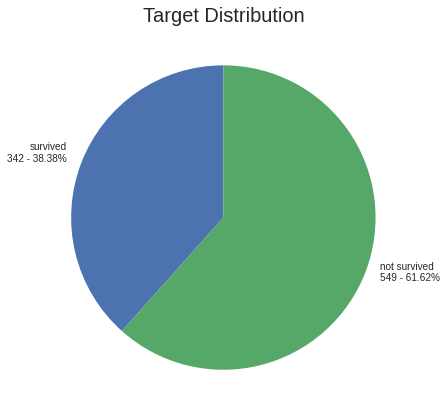

In [157]:
# exolore whit matplotlib
# how is distribuite the target?
plt.style.use('seaborn')
plt.figure(figsize=(10, 7))
plt.title('Target Distribution', fontsize=20)
y=[]
s=0
ns=0
for i in train['Survived']:
  if i==1:
    s=s+1
  else:
    ns=ns+1
y.append(s)
y.append(ns)

mylabels = [f'survived\n{s} - {round((s*100)/(s+ns),2)}%\n', f'not survived\n{ns} - {round((ns*100)/(s+ns),2)}%\n']

plt.pie(y, labels = mylabels, startangle = 90)
plt.show()

In [158]:
# since there are NaNs to be entered both in the train and in the test, I combine the 2 db
train_results = train["Survived"].copy() #dataset only with Y
train.drop("Survived", axis=1, inplace=True, errors="ignore") # I take off from train Y 
titanic = pd.concat([train, test], keys=['train','test'])
# I concatenate the 2 datasets using a multiindex (hierarchical) as the indexes overlap

In [159]:
print(titanic.info())
print()
print(titanic.isna().sum())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 163.3+ KB
None

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [160]:
titanic.sample(3)

PassengerId  Pclass  ...  Cabin Embarked
test  100          992       1  ...   C116        C
      106          998       3  ...    NaN        Q
train 715          716       3  ...  F G73        S

[3 rows x 11 columns]

##Pre-processing

###Feature engineering

In [161]:
'''The same ticket is made out to several people.
I calculate the total number of people for whom the ticket owned by each passenger was purchased
Lo stesso biglietto è intestato a diverse persone.
Calcolo il totale delle persone per cui è stato comprato il biglietto posseduto da ogni passeggeto'''

titanic['TicketCrew'] = titanic['Ticket'].map(titanic['Ticket'].value_counts())

'''Fare is the total price of the ticket, not the cost per person. I calculate the fare per person.
Fare è il prezzo totale del biglietto, non il costo a persona. Calcolo il costo a persona.'''

titanic['FarePerPerson'] = round(titanic['Fare']/titanic['TicketCrew'], 3)

In [162]:
# Now I'm dealing with Name. First I split the family name, then the title.
# Ora mi occupo di Name. Prima splitto il nome di famiglia, poi il titolo.
titanic['Title'] = titanic['Name'].map(lambda x: x.split(',')[1].split('.')[0].lstrip())
titanic['FamilyName'] = titanic['Name'].map(lambda x: x.split(',')[0])
titanic['FamilyCrew'] = titanic['SibSp'] + titanic['Parch']+1
'''Attention: FamilyCrew indicates the family members on board, TicketCrew to how many people the ticket was made out to.
The two fields do not coincide: some people have also bought tickets for the servants
Attenzione: FamilyCrew indica i famigliari a bordo, TicketCrew a quante persone era intestato il biglietto.
I due campi non coincidono: alcune persone hanno acquistato il biglietto anche per i domestici'''

'Attention: FamilyCrew indicates the family members on board, TicketCrew to how many people the ticket was made out to.\nThe two fields do not coincide: some people have also bought tickets for the servants\nAttenzione: FamilyCrew indica i famigliari a bordo, TicketCrew a quante persone era intestato il biglietto.\nI due campi non coincidono: alcune persone hanno acquistato il biglietto anche per i domestici'

In [163]:
titanic.sample(3)

PassengerId  Pclass  ... FamilyName FamilyCrew
train 588          589       3  ...   Gilinski          1
      859          860       3  ...       Razi          1
test  82           974       1  ...       Case          1

[3 rows x 16 columns]

In [164]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Pclass         1309 non-null   int64  
 2   Name           1309 non-null   object 
 3   Sex            1309 non-null   object 
 4   Age            1046 non-null   float64
 5   SibSp          1309 non-null   int64  
 6   Parch          1309 non-null   int64  
 7   Ticket         1309 non-null   object 
 8   Fare           1308 non-null   float64
 9   Cabin          295 non-null    object 
 10  Embarked       1307 non-null   object 
 11  TicketCrew     1309 non-null   int64  
 12  FarePerPerson  1308 non-null   float64
 13  Title          1309 non-null   object 
 14  FamilyName     1309 non-null   object 
 15  FamilyCrew     1309 non-null   int64  
dtypes: float64(3), int64(6), object(7)
memory usage: 214.5+ KB


In [165]:
print('Title')
print(f"{titanic['Title'].value_counts()} \n")
print('FamilyCrew')
print(f"{titanic['FamilyCrew'].value_counts()} \n")
print('TicketCrew')
print(f"{titanic['TicketCrew'].value_counts()} \n")

Title
Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Sir               1
Mme               1
Jonkheer          1
Lady              1
the Countess      1
Don               1
Capt              1
Dona              1
Name: Title, dtype: int64 

FamilyCrew
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilyCrew, dtype: int64 

TicketCrew
1     713
2     264
3     147
4      64
7      35
5      35
6      24
8      16
11     11
Name: TicketCrew, dtype: int64 



In [166]:
print(f'Elenco valori unici: {titanic["Cabin"].explode().unique()}')
print()
print(f'Tot. unique: {titanic["Cabin"].value_counts().sum()}')
print()
print(f'Tot. NaN: {titanic["Cabin"].isna().sum()}')

Elenco valori unici: [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34'

In [167]:
'''There are people who have multiple booths, there are many NaNs,
there are some letters that don't refer to decks (the Titanic only had decks A to G).
I divide the deck by the cabin number by taking only the first value that contains a valid deck and the cabin number.
In the case of NaN the cabin number will be 0 and the deck UN
Ci sono persone che hanno più cabine, ci sono molti NaN,
ci sono alcune lettere che non si riferiscono ai ponti (il Titanic aveva solo i ponti da A a G).
Divido il ponte dal numero della cabina prendendo solo il primo valore che contiene un ponte valido e il numero di cabina.
Nel caso di NaN il numero di cabina sarà 0 e il ponte UN'''

titanic['Cabin_num'] = titanic['Cabin'].str.extract('([a-zA-Z][0-9]+)', expand=False)
titanic['Deck'] = titanic['Cabin_num'].str.extract('([a-zA-Z])', expand=False)
titanic['Cabin_num'] = titanic['Cabin_num'].str.extract('([0-9]+)', expand=False)
print('Deck')
print(f"{titanic['Deck'].value_counts()}")
print()
print(f'Tot. unique: {titanic["Deck"].value_counts().sum()}')
print()
print(f'Tot. NaN: {titanic["Deck"].isna().sum()}')
print()
print('Cabin_num')
print(f"{titanic['Cabin_num'].value_counts()}")
print()
print(f'Tot. unique: {titanic["Cabin_num"].value_counts().sum()}')
print()
print(f'Tot. NaN: {titanic["Cabin_num"].isna().sum()}')

Deck
C    94
B    65
E    44
D    42
A    22
F    13
G     9
Name: Deck, dtype: int64

Tot. unique: 289

Tot. NaN: 1020

Cabin_num
6      9
33     8
101    7
22     7
23     7
      ..
105    1
94     1
87     1
3      1
103    1
Name: Cabin_num, Length: 104, dtype: int64

Tot. unique: 289

Tot. NaN: 1020


In [168]:
titanic.sample(10)

PassengerId  Pclass  ... Cabin_num Deck
test  183         1075       3  ...       NaN  NaN
train 116          117       3  ...       NaN  NaN
      410          411       3  ...       NaN  NaN
      784          785       3  ...       NaN  NaN
      510          511       3  ...       NaN  NaN
      736          737       3  ...       NaN  NaN
test  210         1102       3  ...       NaN  NaN
train 353          354       3  ...       NaN  NaN
      824          825       3  ...       NaN  NaN
      815          816       1  ...       102    B

[10 rows x 18 columns]

In [169]:
titanic['Cabin_num'].fillna(0, inplace=True)
titanic['Cabin_num'] = titanic['Cabin_num'].astype(int)
titanic['Deck'].fillna('UN', inplace=True)
titanic['Cabin'].fillna('UN', inplace=True)

In [170]:
titanic.isna().sum()

PassengerId        0
Pclass             0
Name               0
Sex                0
Age              263
SibSp              0
Parch              0
Ticket             0
Fare               1
Cabin              0
Embarked           2
TicketCrew         0
FarePerPerson      1
Title              0
FamilyName         0
FamilyCrew         0
Cabin_num          0
Deck               0
dtype: int64

In [171]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Pclass         1309 non-null   int64  
 2   Name           1309 non-null   object 
 3   Sex            1309 non-null   object 
 4   Age            1046 non-null   float64
 5   SibSp          1309 non-null   int64  
 6   Parch          1309 non-null   int64  
 7   Ticket         1309 non-null   object 
 8   Fare           1308 non-null   float64
 9   Cabin          1309 non-null   object 
 10  Embarked       1307 non-null   object 
 11  TicketCrew     1309 non-null   int64  
 12  FarePerPerson  1308 non-null   float64
 13  Title          1309 non-null   object 
 14  FamilyName     1309 non-null   object 
 15  FamilyCrew     1309 non-null   int64  
 16  Cabin_num      1309 non-null   int64  
 17  Deck           1309 non-null   o

In [172]:
print(titanic.columns)
print(len(titanic.columns))

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'TicketCrew', 'FarePerPerson',
       'Title', 'FamilyName', 'FamilyCrew', 'Cabin_num', 'Deck'],
      dtype='object')
18


###Missing values

In [173]:
# What is missing I impute with a scikitlearn method but to do this
# all variables must be numeric
# Quello che manca lo imputo con un metodo di scikitlearn ma per fare questo
# tutte le variabili devono essere numeriche

'''Variables
ID
PassengerId, Name, Ticket, Cabin, FamilyName

Binary
Sex

Categorical
Pclass, Embarked, Title, Deck

Discrete
SibSp, Parch, TicketCrew, FamilyCrew, Cabin_num

Continue
Age, Fare, FarePerPerson

Ordinal
nan
'''

titanic["Pclass"] = titanic["Pclass"].astype('category')
titanic["Sex"] = titanic["Sex"].astype('category')
titanic["Embarked"] = titanic["Embarked"].astype('category')
titanic["Title"] = titanic["Title"].astype('category')
titanic["Deck"] = titanic["Deck"].astype('category')

In [174]:
# this method is used for both Y when it is binary but not expressed in numbers
# when we have a binary nominal categorical feature not expressed in 0 and 1
# questo metodo si usa sia per Y quando è binario ma non è espresso in numeri
# quando abbiamo una feature categorica nominale binaria non espressa in 0 e 1
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
titanic["Sex_bin"] = lb.fit_transform(titanic[["Sex"]])
#see also label_binarize
#vedi anche label_binarize

In [175]:
titanic["Embarked_cat"] = titanic["Embarked"].cat.codes # ATTENZIONE questo metodo assegna -1 a NaN e un int progressivo da 0 a n in base all'ordine alfabetico dei values
titanic["Title_cat"] = titanic["Title"].cat.codes
titanic["Deck_cat"] = titanic["Deck"].cat.codes
titanic["Pclass_cat"] = titanic["Pclass"].cat.codes # passo anche oclass perchè è una categorica da 1 a 3 ma deve essere da 0 a 2
titanic[["Pclass_cat", "Embarked_cat", "Title_cat", "Deck_cat"]].replace(-1, np.NaN)
print(titanic.info())
print()
print(titanic.isna().sum())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    1309 non-null   int64   
 1   Pclass         1309 non-null   category
 2   Name           1309 non-null   object  
 3   Sex            1309 non-null   category
 4   Age            1046 non-null   float64 
 5   SibSp          1309 non-null   int64   
 6   Parch          1309 non-null   int64   
 7   Ticket         1309 non-null   object  
 8   Fare           1308 non-null   float64 
 9   Cabin          1309 non-null   object  
 10  Embarked       1307 non-null   category
 11  TicketCrew     1309 non-null   int64   
 12  FarePerPerson  1308 non-null   float64 
 13  Title          1309 non-null   category
 14  FamilyName     1309 non-null   object  
 15  FamilyCrew     1309 non-null   int64   
 16  Cabin_num      1309 non-null   int64   
 17  Deck         

In [176]:
test = titanic[['Title_cat',
      'Parch', 'SibSp', 'Age']]
imp = IterativeImputer(max_iter=10, min_value=titanic['Age'].min(), max_value=titanic['Age'].max(), random_state=0)
imp.fit(test)
X = test
# the model learns that the second feature is double the first
titanicindex = titanic.index
a = pd.DataFrame(imp.transform(X), index=titanicindex)
a

0    1    2          3
train 0    12.0  0.0  1.0  22.000000
      1    13.0  0.0  1.0  38.000000
      2     9.0  0.0  0.0  26.000000
      3    13.0  0.0  1.0  35.000000
      4    12.0  0.0  0.0  35.000000
...         ...  ...  ...        ...
test  413  12.0  0.0  0.0  33.158422
      414   3.0  0.0  0.0  39.000000
      415  12.0  0.0  0.0  38.500000
      416  12.0  0.0  0.0  33.158422
      417   8.0  1.0  1.0  21.346110

[1309 rows x 4 columns]

In [177]:
titanic[['Title_cat',
      'Parch', 'SibSp', 'Age']] = a[[0,1,2,3]]
titanic.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         2
TicketCrew       0
FarePerPerson    1
Title            0
FamilyName       0
FamilyCrew       0
Cabin_num        0
Deck             0
Sex_bin          0
Embarked_cat     0
Title_cat        0
Deck_cat         0
Pclass_cat       0
dtype: int64

In [178]:
ab = titanic[titanic['FarePerPerson'].isna()]
ab

,,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketCrew,FarePerPerson,Title,FamilyName,FamilyCrew,Cabin_num,Deck,Sex_bin,Embarked_cat,Title_cat,Deck_cat,Pclass_cat
test,152,1044,3,"Storey, Mr. Thomas",male,60.5,0.0,0.0,3701,NaN,UN,S,1,NaN,Mr,Storey,1,0,UN,1,2,12.0,7,2


In [179]:
test = titanic[['Title_cat',
      'Parch', 'SibSp', 'FarePerPerson', 'Pclass_cat', 'Deck_cat','TicketCrew']]
imp = IterativeImputer(max_iter=10, min_value=titanic['FarePerPerson'].min(), max_value=titanic['FarePerPerson'].max(), random_state=0)
imp.fit(test)
X = test
# the model learns that the second feature is double the first
titanicindex = titanic.index
a = pd.DataFrame(imp.transform(X), index=titanicindex)
a

0    1    2       3    4    5    6
train 0    12.0  0.0  1.0   7.250  2.0  7.0  1.0
      1    13.0  0.0  1.0  35.642  0.0  2.0  2.0
      2     9.0  0.0  0.0   7.925  2.0  7.0  1.0
      3    13.0  0.0  1.0  26.550  0.0  2.0  2.0
      4    12.0  0.0  0.0   8.050  2.0  7.0  1.0
...         ...  ...  ...     ...  ...  ...  ...
test  413  12.0  0.0  0.0   8.050  2.0  7.0  1.0
      414   3.0  0.0  0.0  36.300  0.0  2.0  3.0
      415  12.0  0.0  0.0   7.250  2.0  7.0  1.0
      416  12.0  0.0  0.0   8.050  2.0  7.0  1.0
      417   8.0  1.0  1.0   7.453  2.0  7.0  3.0

[1309 rows x 7 columns]

In [180]:
titanic[['FarePerPerson']] = a[[3]]
titanic.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         2
TicketCrew       0
FarePerPerson    0
Title            0
FamilyName       0
FamilyCrew       0
Cabin_num        0
Deck             0
Sex_bin          0
Embarked_cat     0
Title_cat        0
Deck_cat         0
Pclass_cat       0
dtype: int64

In [181]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    1309 non-null   int64   
 1   Pclass         1309 non-null   category
 2   Name           1309 non-null   object  
 3   Sex            1309 non-null   category
 4   Age            1309 non-null   float64 
 5   SibSp          1309 non-null   float64 
 6   Parch          1309 non-null   float64 
 7   Ticket         1309 non-null   object  
 8   Fare           1308 non-null   float64 
 9   Cabin          1309 non-null   object  
 10  Embarked       1307 non-null   category
 11  TicketCrew     1309 non-null   int64   
 12  FarePerPerson  1309 non-null   float64 
 13  Title          1309 non-null   category
 14  FamilyName     1309 non-null   object  
 15  FamilyCrew     1309 non-null   int64   
 16  Cabin_num      1309 non-null   int64   
 17  Deck         

In [182]:
titanic.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'TicketCrew', 'FarePerPerson',
       'Title', 'FamilyName', 'FamilyCrew', 'Cabin_num', 'Deck', 'Sex_bin',
       'Embarked_cat', 'Title_cat', 'Deck_cat', 'Pclass_cat'],
      dtype='object')

In [183]:
titanic_01 = titanic[['PassengerId', 'Age', 'SibSp', 'Parch', 'TicketCrew', 'FarePerPerson',
      'FamilyCrew', 'Cabin_num', 'Sex_bin',
      'Embarked_cat', 'Title_cat', 'Deck_cat', 'Pclass_cat']]

In [184]:
titanic_01.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Age            1309 non-null   float64
 2   SibSp          1309 non-null   float64
 3   Parch          1309 non-null   float64
 4   TicketCrew     1309 non-null   int64  
 5   FarePerPerson  1309 non-null   float64
 6   FamilyCrew     1309 non-null   int64  
 7   Cabin_num      1309 non-null   int64  
 8   Sex_bin        1309 non-null   int64  
 9   Embarked_cat   1309 non-null   int8   
 10  Title_cat      1309 non-null   float64
 11  Deck_cat       1309 non-null   int8   
 12  Pclass_cat     1309 non-null   int8   
dtypes: float64(5), int64(5), int8(3)
memory usage: 156.9+ KB


In [185]:
titanic_01.sample(5)

,,PassengerId,Age,SibSp,Parch,TicketCrew,FarePerPerson,FamilyCrew,Cabin_num,Sex_bin,Embarked_cat,Title_cat,Deck_cat,Pclass_cat
train,648,649,33.158422,0.0,0.0,1,7.550,1,0,1,2,12.0,7,2
test,415,1307,38.500000,0.0,0.0,1,7.250,1,0,1,2,12.0,7,2
train,585,586,18.000000,0.0,2.0,3,26.550,3,68,0,2,9.0,4,0
test,17,909,21.000000,0.0,0.0,1,7.225,1,0,1,0,12.0,7,2
train,211,212,35.000000,0.0,0.0,2,10.500,1,0,0,2,9.0,7,1


In [186]:
titanic_01[['SibSp', 'Parch', 'TicketCrew', 'FamilyCrew', 'Cabin_num']] = titanic[['SibSp', 'Parch', 'TicketCrew', 'FamilyCrew', 'Cabin_num']].astype('int')
titanic_01[['Sex_bin',
       'Embarked_cat', 'Title_cat', 'Deck_cat', 'Pclass_cat']] = titanic[['Sex_bin',
       'Embarked_cat', 'Title_cat', 'Deck_cat', 'Pclass_cat']].astype('int').astype('str')
titanic_01['Age'] = titanic_01['Age'].round(1)
titanic_01['FarePerPerson'] = titanic_01['FarePerPerson'].round(3)

In [187]:
titanic_01.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 417)
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Age            1309 non-null   float64
 2   SibSp          1309 non-null   int64  
 3   Parch          1309 non-null   int64  
 4   TicketCrew     1309 non-null   int64  
 5   FarePerPerson  1309 non-null   float64
 6   FamilyCrew     1309 non-null   int64  
 7   Cabin_num      1309 non-null   int64  
 8   Sex_bin        1309 non-null   object 
 9   Embarked_cat   1309 non-null   object 
 10  Title_cat      1309 non-null   object 
 11  Deck_cat       1309 non-null   object 
 12  Pclass_cat     1309 non-null   object 
dtypes: float64(2), int64(6), object(5)
memory usage: 183.8+ KB


In [188]:
titanic_01.sample(5)

PassengerId   Age  SibSp  ...  Title_cat  Deck_cat  Pclass_cat
train 297          298   2.0      1  ...          9         2           0
      367          368  35.2      0  ...         13         7           2
test  291         1183  30.0      0  ...          9         7           2
      138         1030  23.0      0  ...          9         7           2
train 67            68  19.0      0  ...         12         7           2

[5 rows x 13 columns]

In [189]:
# Train
train_01 = titanic_01.loc['train']
train_01['Survived'] = train_results.astype('str')

# Test
test_01 = titanic_01.loc['test']

In [190]:
print(train_01.info())
train_01.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Age            891 non-null    float64
 2   SibSp          891 non-null    int64  
 3   Parch          891 non-null    int64  
 4   TicketCrew     891 non-null    int64  
 5   FarePerPerson  891 non-null    float64
 6   FamilyCrew     891 non-null    int64  
 7   Cabin_num      891 non-null    int64  
 8   Sex_bin        891 non-null    object 
 9   Embarked_cat   891 non-null    object 
 10  Title_cat      891 non-null    object 
 11  Deck_cat       891 non-null    object 
 12  Pclass_cat     891 non-null    object 
 13  Survived       891 non-null    object 
dtypes: float64(2), int64(6), object(6)
memory usage: 104.4+ KB
None


,PassengerId,Age,SibSp,Parch,TicketCrew,FarePerPerson,FamilyCrew,Cabin_num,Sex_bin,Embarked_cat,Title_cat,Deck_cat,Pclass_cat,Survived
591,592,52.0,1,0,2,39.133,2,20,0,0,13,3,0,1
387,388,36.0,0,0,1,13.000,1,0,0,2,9,7,1,1
432,433,42.0,1,0,2,13.000,2,0,0,2,13,7,1,1


In [191]:
print(test_01.info())
test_01.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Age            418 non-null    float64
 2   SibSp          418 non-null    int64  
 3   Parch          418 non-null    int64  
 4   TicketCrew     418 non-null    int64  
 5   FarePerPerson  418 non-null    float64
 6   FamilyCrew     418 non-null    int64  
 7   Cabin_num      418 non-null    int64  
 8   Sex_bin        418 non-null    object 
 9   Embarked_cat   418 non-null    object 
 10  Title_cat      418 non-null    object 
 11  Deck_cat       418 non-null    object 
 12  Pclass_cat     418 non-null    object 
dtypes: float64(2), int64(6), object(5)
memory usage: 45.7+ KB
None


,PassengerId,Age,SibSp,Parch,TicketCrew,FarePerPerson,FamilyCrew,Cabin_num,Sex_bin,Embarked_cat,Title_cat,Deck_cat,Pclass_cat
327,1219,46.0,0,0,2,39.600,1,0,1,0,12,7,0
116,1008,33.2,0,0,1,6.438,1,0,1,0,12,7,2
328,1220,29.0,1,0,2,13.000,2,0,1,2,12,7,1


In [192]:
train_01.to_csv(f'{staging}train_01.csv', index=False)
test_01.to_csv(f'{staging}test_01.csv', index=False)

## Stat Explore

In [193]:
# funzione per il calcolo del Chi_Square
# Serve la tabella del Chi_Square per il terzo valore
def chi2_by_hand (df, col1, col2, probability):
    #---crea la tabella delle contingenze--- 
    df_cont = pd.crosstab(index = df[col1], columns = df[col2]) 
    # display(df_cont)
    #---calcola il grado di libertà--- 
    degree_f = (df_cont.shape[0]-1) * (df_cont.shape[1]-1)
    #---somma i totali per riga e colonne--- 
    df_cont.loc[:,'Total']= df_cont.sum(axis=1) 
    df_cont.loc['Total']= df_cont.sum() 
    # print( '---Osservato (O)---') 
    # display(df_cont)
    #---crea il dataframe del valore atteso--- 
    df_exp = df_cont.copy()     
    df_exp.iloc[:,:] = np.multiply.outer(df_cont.sum(1).values,df_cont.sum().values)/df_cont.sum().sum()             
    # print('---Expected (E)---') 
    # display(df_exp) 
        
    # calcola i valori chi-quadrato 
    df_chi2 = ((df_cont - df_exp)**2) / df_exp     
    df_chi2.loc[:,'Total']= df_chi2.sum(axis=1) 
    df_chi2.loc['Total']= df_chi2.sum() 
    
    # print('---Chi-Square---') 
    # display(df_chi2 )
    #---get chi- 
    chi_square_score = df_chi2.iloc[:-1,:-1].sum().sum()
    from scipy import stats
    p = stats.distributions.chi2.sf(chi_square_score, degree_f)
    p = format(p, '.5f')
    int(degree_f)
    prob = chi_square_table[probability][degree_f-1:degree_f]
    prob = round(float(prob), 3)
    
    return chi_square_score, prob, degree_f, p

In [194]:
for i in train_01.columns:
  if(train_01[i].dtype == object):
    chi_score, prob, degree_f, p = chi2_by_hand(train_01, 'Survived', i, '0.05')
    print(f'Chi2_score {i}: {chi_score} | Chi2_table: {prob} | Degrees of freedom: {degree_f} | P-Value: {p}')

  else:
    print(f'{i} is not str. {i} is {train_01[i].dtype}')

PassengerId is not str. PassengerId is int64
Age is not str. Age is float64
SibSp is not str. SibSp is int64
Parch is not str. Parch is int64
TicketCrew is not str. TicketCrew is int64
FarePerPerson is not str. FarePerPerson is float64
FamilyCrew is not str. FamilyCrew is int64
Cabin_num is not str. Cabin_num is int64
Chi2_score Sex_bin: 263.05057407065567 | Chi2_table: 3.841 | Degrees of freedom: 1 | P-Value: 0.00000
Chi2_score Embarked_cat: 29.670614191394378 | Chi2_table: 7.815 | Degrees of freedom: 3 | P-Value: 0.00000
Chi2_score Title_cat: 300.02302134972405 | Chi2_table: 26.296 | Degrees of freedom: 16 | P-Value: 0.00000
Chi2_score Deck_cat: 101.56081372484479 | Chi2_table: 14.067 | Degrees of freedom: 7 | P-Value: 0.00000
Chi2_score Pclass_cat: 102.88898875696057 | Chi2_table: 5.991 | Degrees of freedom: 2 | P-Value: 0.00000
Chi2_score Survived: 890.9999999999999 | Chi2_table: 3.841 | Degrees of freedom: 1 | P-Value: 0.00000


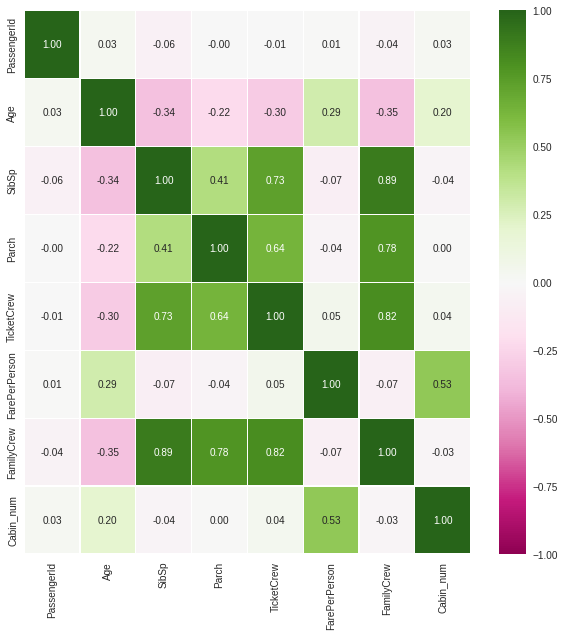

In [195]:
# train_01 = train_01.astype(float)
corr_matrix = train_01.corr(method='pearson', min_periods=train_01.shape[0])

fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(corr_matrix,
                linewidths=0.3,
                fmt='.2f',
                cmap="PiYG",
                annot=True,
                vmin=-1, vmax=1);

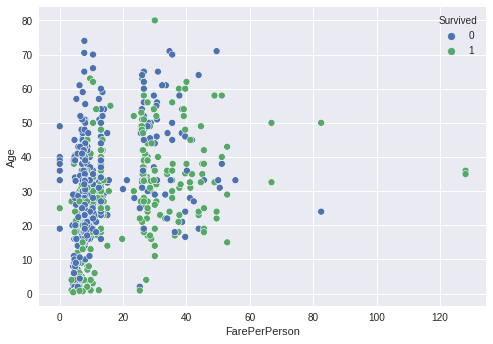

In [196]:
sns.scatterplot(data=train_01, x="FarePerPerson", y="Age", hue="Survived")

##Predictive Modeling

###Separe test and train

In [197]:
yAll = train_01["Survived"]
xAll = train_01.drop("Survived", axis=1)

xTrain, xTest, yTrain, yTest = train_test_split(xAll,yAll,
                                    test_size = 0.3, 
                                    random_state = 0,
                                    stratify=yAll, # stratify uses yAll information to obtain proportionally distributed subsets  
                               )

print(f'xAll.shape: {xAll.shape} and yAll.shape: {yAll.shape}')
print(f'xTrain.shape: {xTrain.shape} and xTest.shape: {xTest.shape}')
print(f'yTrain.shape: {yTrain.shape} and yTest.shape: {yTest.shape}')

xAll.shape: (891, 13) and yAll.shape: (891,)
xTrain.shape: (623, 13) and xTest.shape: (268, 13)
yTrain.shape: (623,) and yTest.shape: (268,)


In [198]:
xTrain.columns

Index(['PassengerId', 'Age', 'SibSp', 'Parch', 'TicketCrew', 'FarePerPerson',
       'FamilyCrew', 'Cabin_num', 'Sex_bin', 'Embarked_cat', 'Title_cat',
       'Deck_cat', 'Pclass_cat'],
      dtype='object')

In [199]:
col = ['Age', 'Sex_bin', 'Title_cat', 'Pclass_cat']

# col_01 = ['Age', 'FamilyCrew', 'FarePerPerson', 'Sex_bin',
#           'Deck_cat', 'Title_cat', 'Pclass_cat']

# col_02 = ['Age', 'SibSp', 'Parch', 'TicketCrew', 'FarePerPerson',
#        'FamilyCrew', 'Cabin_num', 'Sex_bin', 'Embarked_cat', 'Title_cat',
#        'Deck_cat', 'Pclass_cat']

###Decision Tree

In [200]:
%%time

clf_0 = tree.DecisionTreeClassifier()
clf_0 = clf_0.fit(xTrain[col], yTrain)
yPred_train = clf_0.predict(xTrain[col])
yPred_test = clf_0.predict(xTest[col])
clf_train = classification_report(yTrain, yPred_train)
clf_test = classification_report(yTest, yPred_test)
print("Train")
print(clf_train)
print()
print("Test")
print(clf_test)

Train
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       384
           1       0.94      0.80      0.86       239

    accuracy                           0.90       623
   macro avg       0.91      0.88      0.89       623
weighted avg       0.91      0.90      0.90       623


Test
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       165
           1       0.88      0.71      0.78       103

    accuracy                           0.85       268
   macro avg       0.86      0.82      0.84       268
weighted avg       0.85      0.85      0.85       268

CPU times: user 51.4 ms, sys: 1.78 ms, total: 53.1 ms
Wall time: 53.6 ms


In [ ]:
%%time

clsf = DecisionTreeClassifier()
max_depth_range=range(1, 20)
min_samples_leaf_range=range(1, 50)
min_samples_split_range=range(2,10)
 
paramSpace = {
    'criterion': ['entropy', 'gini'], 
    'max_depth': max_depth_range,
    'min_samples_leaf': min_samples_leaf_range,
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'min_samples_split': min_samples_split_range
}

scoringMetric = make_scorer(accuracy_score)

# make_scorer(precision_score)
# make_scorer(recall_score)


gs = GridSearchCV(clsf, param_grid=paramSpace, scoring=scoringMetric, cv=5)
gs.fit(xTrain[col],yTrain)
print(gs.best_params_)
print(gs.best_score_)

In [139]:
%%time

clsf =  DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, max_features=None, min_samples_split=2)
clsf.fit(xTrain[col],yTrain)
yPred_train = clsf.predict(xTrain[col])
yPred_test = clsf.predict(xTest[col])
clf_train = classification_report(yTrain, yPred_train)
clf_test = classification_report(yTest, yPred_test)

print("TRAIN")
print(clf_train)
print("ASE (RMSE)")
print(mean_squared_error(yTrain, yPred_train, squared=False))
print("ASE (MSE)")
print(mean_squared_error(yTrain, yPred_train, squared=True))
print()
print()
print("TEST")
print(clf_test)
print("ASE (RMSE)")
print(mean_squared_error(yTest, yPred_test, squared=False))
print("ASE (MSE)")
print(mean_squared_error(yTest, yPred_test, squared=True))
print()
print()

TRAIN
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       384
           1       0.95      0.53      0.68       239

    accuracy                           0.81       623
   macro avg       0.86      0.75      0.77       623
weighted avg       0.84      0.81      0.79       623

ASE (RMSE)
0.4388808179809791
ASE (MSE)
0.1926163723916533


TEST
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       165
           1       0.94      0.47      0.62       103

    accuracy                           0.78       268
   macro avg       0.84      0.72      0.74       268
weighted avg       0.82      0.78      0.76       268

ASE (RMSE)
0.46520738434354325
ASE (MSE)
0.21641791044776118


CPU times: user 57.8 ms, sys: 1.02 ms, total: 58.8 ms
Wall time: 57.1 ms


ROC


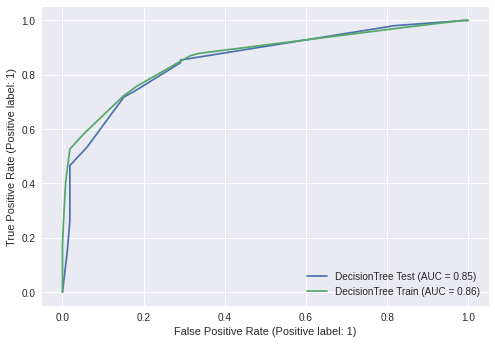

In [140]:
print('ROC')
disp = plot_roc_curve(clsf, xTest[col], yTest, name='DecisionTree Test');
plot_roc_curve(clsf, xTrain[col], yTrain, ax=disp.ax_, name='DecisionTree Train');

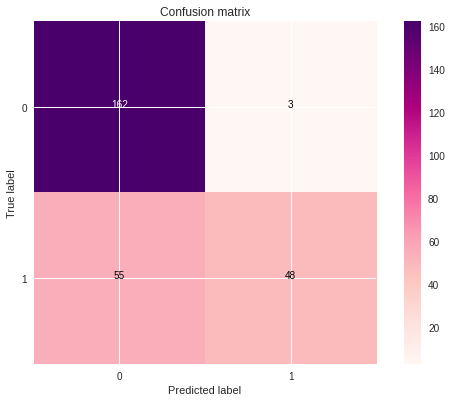

In [141]:
cm=confusion_matrix(yTest, yPred_test)
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix', # This is an optional parameter with a default value
                          cmap=plt.cm.RdPu         # Selecting the blue tone palette of colors
                         ): # This is a python function
    """
    This function prints and plots the confusion matrix.
    """
    plt.clf() 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
 
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(cm, ["0","1"])

##Submission

In [142]:
yTrain = train_01["Survived"]
xTrain = train_01.drop("Survived", axis=1)
xTest = test_01

print(f'xTrain.shape: {xTrain.shape} and xTest.shape: {xTest.shape}')
print(f'yTrain.shape: {yTrain.shape}')

xTrain.shape: (891, 13) and xTest.shape: (418, 13)
yTrain.shape: (891,)


In [143]:
%%time

clsf =  DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, max_features=None, min_samples_split=2)
clsf.fit(xTrain[col],yTrain)
yPred_train = clsf.predict(xTrain[col])
yPred_test = clsf.predict(xTest[col])
clf_train = classification_report(yTrain, yPred_train)

print("Train")
print(clf_train)

Train
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       549
           1       0.95      0.51      0.66       342

    accuracy                           0.80       891
   macro avg       0.86      0.74      0.76       891
weighted avg       0.83      0.80      0.78       891

CPU times: user 56.6 ms, sys: 0 ns, total: 56.6 ms
Wall time: 58.5 ms


Confusion matrix


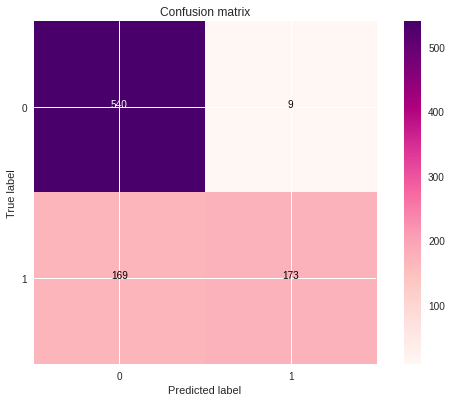

In [144]:
print("Confusion matrix")
cm=confusion_matrix(yTrain, yPred_train)
plot_confusion_matrix(cm, ["0","1"])

In [145]:
submission = pd.DataFrame({
        "PassengerId": xTest["PassengerId"],
        "Survived": yPred_test
     })
submission.to_csv(f'{staging}/submission.csv', index=False)

'''
Submission File Format:

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

PassengerId (sorted in any order)
Survived (contains your binary predictions: 1 for survived, 0 for deceased)

'''

def local_time():
    # dd/mm/YY H:M:S
    print("Finished at " + datetime.datetime.now().strftime("%H:%M:%S"))	

local_time()

Finished at 12:41:02


In [146]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  418 non-null    int64 
 1   Survived     418 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


### Kaggle score
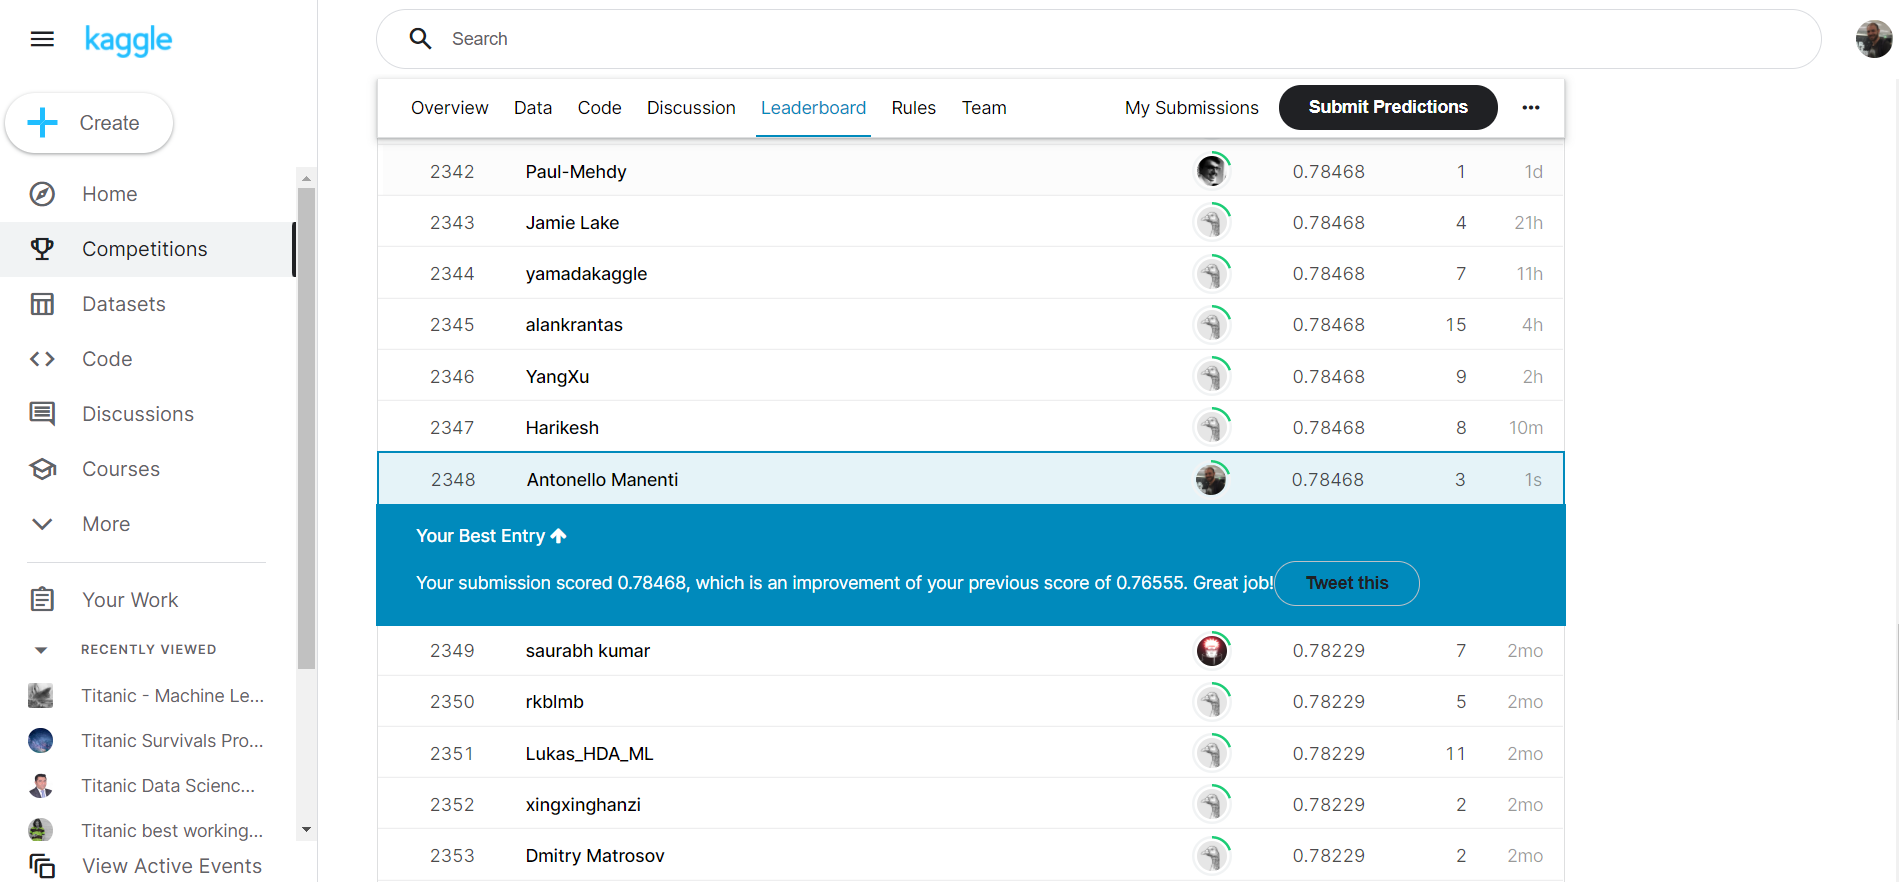

My accuracy is 0.78468
I ranked 2348th out of 13879th (06/01/2022)
Best 17% 💪

The default gender_submission's score is 0.76555!